<a href="https://colab.research.google.com/github/Arvinth-s/MIMO/blob/main/Spatial_mimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [4]:
target_dir = 'content/drive/MyDrive/Antenna/project/'

In [5]:
import torch.nn as nn
import torch.nn.functional as  F
from torch import optim
import torch

In [6]:
import random
import math
import cmath

In [12]:
mt = 100
mr = 200
Nt = 2
Nr = 3

In [53]:
class Net(nn.Module):
  def __init__(self):
      super().__init__()
      
      # Inputs to hidden layer linear transformation
      self.linear1 = nn.Linear(Nt, 500)
      self.linear2 = nn.Linear(500, 2*mt)
      self.tren_layer = nn.Linear(2*mt, 2*mr)
      # Define sigmoid activation and softmax output 
      self.linear3 = nn.Linear(2*mr, 500)
      self.linear4 = nn.Linear(500, Nt)
      self.output = nn.Sigmoid()
      self.softmax = nn.Softmax(dim=1)

      self.encoder= True
      self.var = 1
        
  def channel(self, x):
      ch = np.random.randn(mr, mt) + 1j*np.random.randn(mr, mt)
      n = np.random.normal(0, self.var/1000000, (mr, 2)).view(np.complex128)
      y = np.array(x.detach())
      y = y.reshape(y.shape[0], int(y.shape[1]/2), 2).view(np.complex64)
      y = y[:, :].squeeze()
      y = np.matmul(y, np.transpose(ch))
      y = y/np.linalg.norm(y)
      n = np.repeat(n, y.shape[0], axis=1)
      y = y + np.transpose(n)
      x = torch.tensor(y, requires_grad=False)
      x = torch.view_as_real(x)
      x = torch.reshape(x, (x.shape[0], x.shape[1]*2))
      x = x.float()
      x.requires_grad=True
      return x

  def train_encoder(self, val = False):
      self.encoder = val
      lt = 2
      ct = 0
      for child in model.children():
        if(ct >= 2):
          break
        ct += 1
        for param in child.parameters():
          param.requires_grad=val
  def update_variance(self, var = 1):
    self.var = var

  def forward(self, x):
      # Pass the input tensor through each of our operations
      # y = x
      x = self.linear1(x)
      x = self.linear2(x)
      if (self.encoder == False):
        x = self.channel(x)
      else:
        x = self.tren_layer(x)
      x = self.linear3(x)
      x = self.linear4(x)
      x = self.output(x)
      
      return x

In [54]:
model = Net()
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()

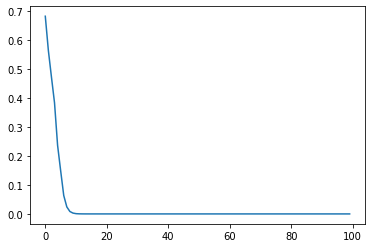

In [55]:
#training encoder
losses = []
epochs = 100
model.train_encoder(True)
for epoch in range(epochs):
  optimizer.zero_grad()
  x = torch.tensor(np.random.randint(0, 2, (100)), dtype = torch.float32)
  x = x.repeat(Nt, 1)
  x = torch.transpose(x, 0, 1)
  pred = model(x)
  loss = criterion(pred, x)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
plt.plot(np.arange(len(losses)), losses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


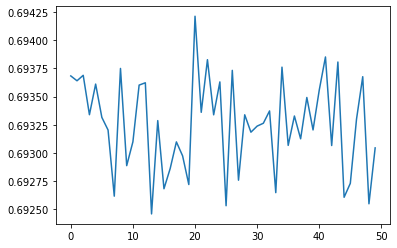

In [56]:
lr = 5e-6
epochs = 50
batch_size = 100
model.train_encoder(False)
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()
losses = []
for epoch in range(epochs):
  print(epoch)
  batch_loss = []
  for batch in range(batch_size):
    optimizer.zero_grad()
    x = torch.tensor(np.random.randint(0, 2, (100)), dtype = torch.float32)
    x = x.repeat(Nt, 1)
    x = torch.transpose(x, 0, 1)
    pred = model(x)
    loss = criterion(pred, x)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  losses.append(sum(batch_loss)/len(batch_loss))
plt.plot(np.arange(len(losses)), losses)

In [41]:
target_dir = '/content/drive/MyDrive/Antenna/project/'
k = input()
torch.save(model, target_dir + 'weights/model/' + k + '.pt')
torch.save(optimizer, target_dir + 'weights/optimizer/' + k + '.pt')

mimo-spatial


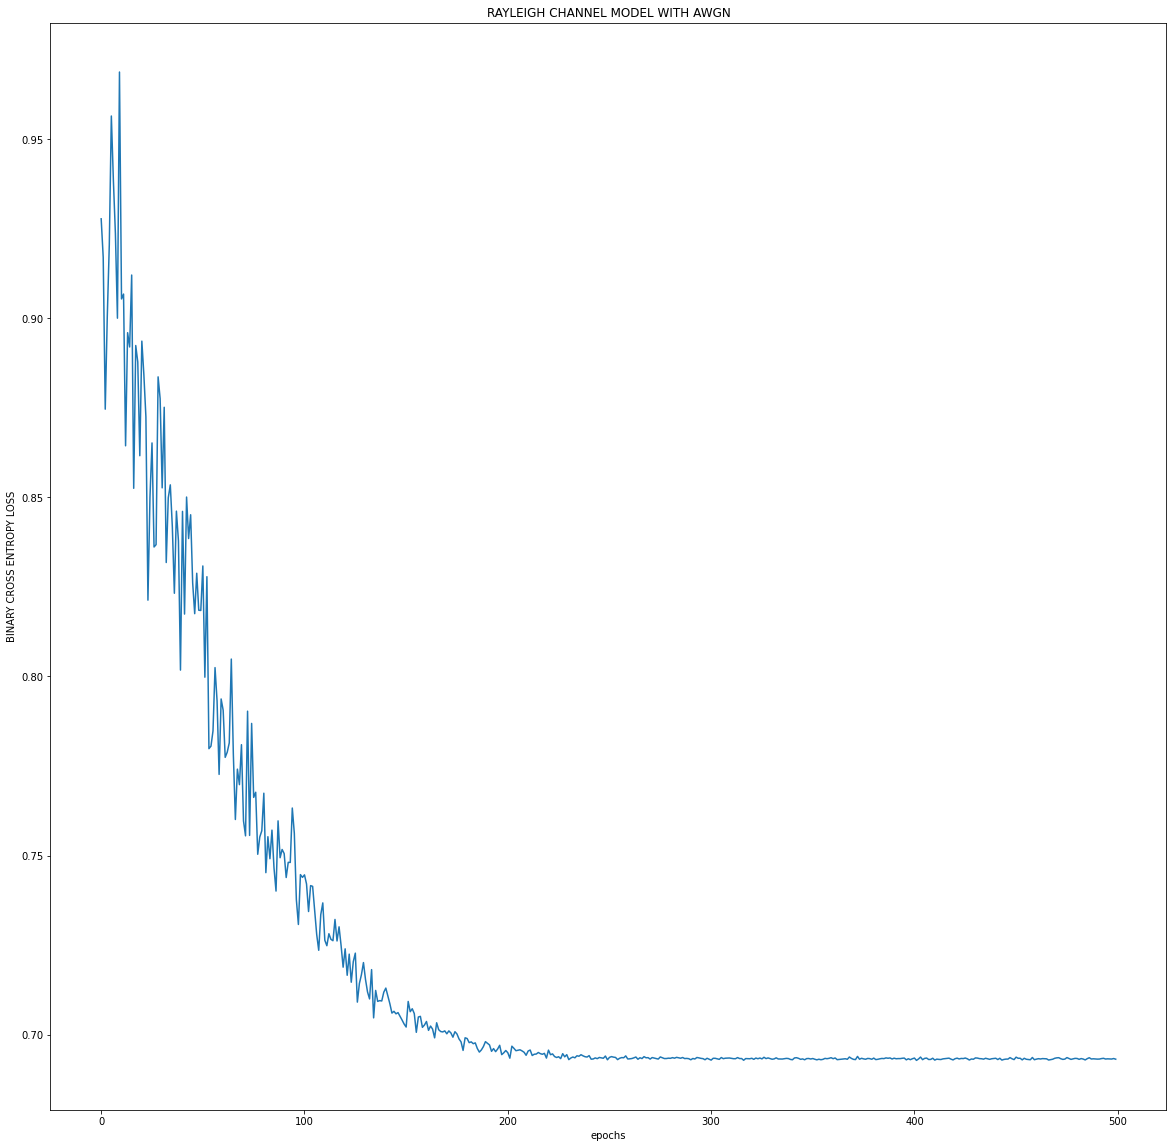

In [42]:
fig = plt.figure(figsize=(20, 20))
plt.title('RAYLEIGH CHANNEL MODEL WITH AWGN')
plt.xlabel('epochs')
plt.ylabel('BINARY CROSS ENTROPY LOSS')
plt.plot(np.arange(len(losses)), losses)
plt.savefig(target_dir + 'results/' + 'rayleigh_channel_model_with_AWGN.png')

In [ ]:
variances = np.arange(1, 10, 1)
ber = []
batch_size = 200
model.train_encoder(False)
for var in variances:
  print('completed:', var*1)
  var = var/pow(10, var)
  bit_error_rate = 0
  for batch in range(batch_size):
    x = torch.tensor(np.random.randint(0, 2, (100)), dtype = torch.float32)
    x = x.repeat(Nt, 1)
    x = torch.transpose(x, 0, 1)
    model.update_variance(var)
    pred = model(x)
    # print(pred.shape)
    pred_bit = []
    x = torch.flatten(x)
    pred = torch.flatten(pred)
    for i in range(pred.shape[0]):
      if ((pred[i] >= 0.5 and x[i]== 0) or (pred[i] < 0.5 and x[i]==1)):
        bit_error_rate += 1
  ber.append(bit_error_rate/(batch_size * 101*10))
  print(pred)
  print(x)
print(ber)
plt.plot(np.log2(variances), ber)